In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
index["market_cap"] = index["market_cap"].astype(float)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code").sort_values("market_cap",ascending=False)

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [8]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["ema_volume_corr"],group_percentages=[0.5])

In [9]:
analysises = []
for rolling_window in [20]:
    market.connect()
    prices = []
    for ticker in tqdm(index["ticker"][:500]): 
        try:
            price = market.query("prices", {"ticker": ticker})
            if price.index.size > 150:
                price = p.lower_column(price)
                price = p.utc_date(price)
            
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                price = Indicator.EMAVolumeCorr.calculate(price,timeframe=rolling_window)
                for member in RiskType:
                    price = member.apply(price)
                prices.append(price.dropna())
        except Exception as e:
            print(str(e))
            continue
    market.disconnect()
    model_end = 2015
    backtest_end = 2025
    simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
    simulation["asset_class"] = "common_stock"
    ## subsetting backtesting data
    simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
    simulation.sort_values("date", inplace=True)
    for portfolio in tqdm(portfolios[:1]):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = Metrics.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


In [10]:
a = pd.DataFrame(analysises)
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [11]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
0,0,ema_volume_corr,QUARTER,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.5,3.850194,4.704283,0.818444,1.126084,0.90785,0.621081,1.043391,-1.628415,<financial_common.portfolio_management.portfol...,20


In [19]:
trades

,year,quarter,ticker,date,adjclose,sell_price,sic_description,ema_volume_corr,coefficient_of_variation,risk,group_idx,group_idx_max,group_percentile,position_type,weight,unweighted_return,winsorized_return,return
major_key,,,,,,,,,,,,,,,,,,
20151ACCIDENT & HEALTH INSURANCE,2015,1,AFL,2015-03-31 00:00:00+00:00,23.939257,25.245940,ACCIDENT & HEALTH INSURANCE,8.181036e+05,0.025639,0.025639,1,3.0,0.333,1.0,1,1.054583,1.054583,1.054583
20151AGRICULTURAL CHEMICALS,2015,1,CF,2015-03-31 00:00:00+00:00,41.707372,42.785882,AGRICULTURAL CHEMICALS,2.552159e+06,0.038609,0.038609,1,1.0,1.000,1.0,1,1.025859,1.025859,1.025859
20151AIR COURIER SERVICES,2015,1,FDX,2015-03-31 00:00:00+00:00,149.465892,143.564716,AIR COURIER SERVICES,-2.880743e+06,0.064876,0.064876,1,1.0,1.000,1.0,1,0.960518,0.960518,0.960518
"20151AIR TRANSPORTATION, SCHEDULED",2015,1,DAL,2015-03-31 00:00:00+00:00,43.479607,39.827766,"AIR TRANSPORTATION, SCHEDULED",1.025064e+07,0.110768,0.110768,1,3.0,0.333,1.0,1,0.916010,0.916010,0.916010
20151AIR-COND & WARM AIR HEATG EQUIP & COMM & INDL REFRIG EQUIP,2015,1,LII,2015-03-31 00:00:00+00:00,83.853917,99.323812,AIR-COND & WARM AIR HEATG EQUIP & COMM & INDL ...,2.250172e+05,0.079195,0.079195,1,1.0,1.000,1.0,1,1.184486,1.184486,1.184486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"20244WHOLESALE-GROCERIES, GENERAL LINE",2024,4,PFGC,2024-12-31 00:00:00+00:00,78.160000,84.550000,"WHOLESALE-GROCERIES, GENERAL LINE",2.060116e+06,0.061555,0.061555,1,1.0,1.000,1.0,1,1.081755,1.081755,1.081755
20244WHOLESALE-HARDWARE & PLUMBING & HEATING EQUIPMENT & SUPPLIES,2024,4,FERG,2024-12-31 00:00:00+00:00,197.574690,172.687044,WHOLESALE-HARDWARE & PLUMBING & HEATING EQUIPM...,-1.917815e+06,0.043358,0.043358,2,2.0,1.000,1.0,1,0.874034,0.874034,0.874034
20244WHOLESALE-METALS SERVICE CENTERS & OFFICES,2024,4,RS,2024-12-31 00:00:00+00:00,287.769235,268.146320,WHOLESALE-METALS SERVICE CENTERS & OFFICES,2.167256e+06,0.033306,0.033306,1,1.0,1.000,1.0,1,0.931810,0.931810,0.931810


In [12]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

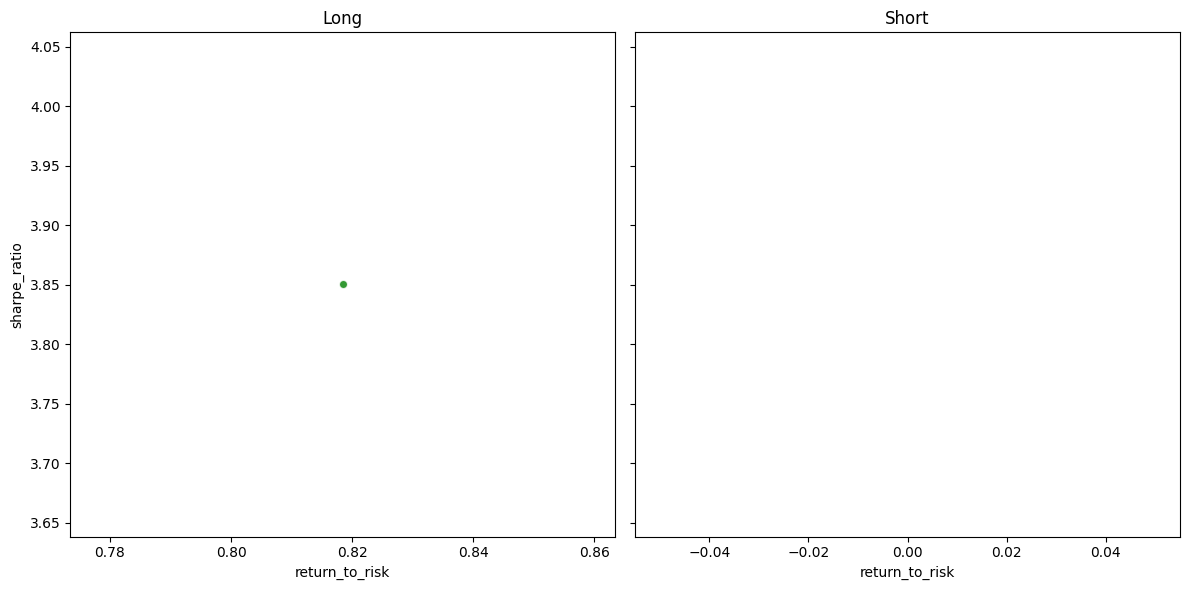

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [16]:
valid = a[(a["timeframe"]=="QUARTER") & (a["position_type"]=="long")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,...,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,color,return_to_risk
0,ema_volume_corr,QUARTER,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,3.850194,...,0.818444,1.126084,0.90785,0.621081,1.043391,-1.628415,<financial_common.portfolio_management.portfol...,20,green,4.704283


In [17]:
top = valid.head(1).to_dict("records")[0]
top

{'ranking_metric': 'ema_volume_corr',
 'timeframe': 'QUARTER',
 'position_type': 'long',
 'grouping_type': 'SIC_DESCRIPTION',
 'selection_type': 'mixed',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-31 00:00:00+0000', tz='UTC'),
 'pnl': 3.8501938745313,
 'coefficient_of_variation': 4.704282948996751,
 'portfolio_std': 0.8184443657566141,
 'average_gain': 1.1260843767968547,
 'average_loss': 0.9078498258526222,
 'win_loss_ratio': 0.6210809196775157,
 'weekly_return': 1.0433911414584758,
 'sharpe_ratio': -1.6284145881467846,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x264d0b1eb90>,
 'rolling_window': 20,
 'color': 'green',
 'return_to_risk': 4.704282948996751}

In [20]:
pm = top["portfolio"]
market.connect()
prices = []
for ticker in tqdm(index["ticker"][:500]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            price = Indicator.EMAVolumeCorr.calculate(price,timeframe=top["rolling_window"])
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.67it/s]


In [21]:
portfolio

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
0,2015-03-31 00:00:00+00:00,1.033764,1.033764,46.010834,1.000000,2015,3,1,14
1,2015-06-30 00:00:00+00:00,1.004291,1.038200,51.807462,1.125984,2015,6,2,27
2,2015-09-30 00:00:00+00:00,0.938021,0.973853,46.917335,1.019702,2015,9,3,40
3,2015-12-31 00:00:00+00:00,1.047111,1.019732,51.178733,1.112319,2015,12,4,53
4,2016-03-31 00:00:00+00:00,1.060242,1.081162,46.217867,1.004500,2016,3,1,13
5,2016-06-30 00:00:00+00:00,1.031474,1.115191,48.857211,1.061863,2016,6,2,26
6,2016-09-30 00:00:00+00:00,1.054627,1.176111,52.766231,1.146822,2016,9,3,39
7,2016-12-30 00:00:00+00:00,1.049009,1.233751,68.869408,1.496809,2016,12,4,52
8,2017-03-31 00:00:00+00:00,1.052474,1.298491,70.493683,1.532111,2017,3,1,13
9,2017-06-30 00:00:00+00:00,1.038269,1.348183,73.770726,1.603334,2017,6,2,26


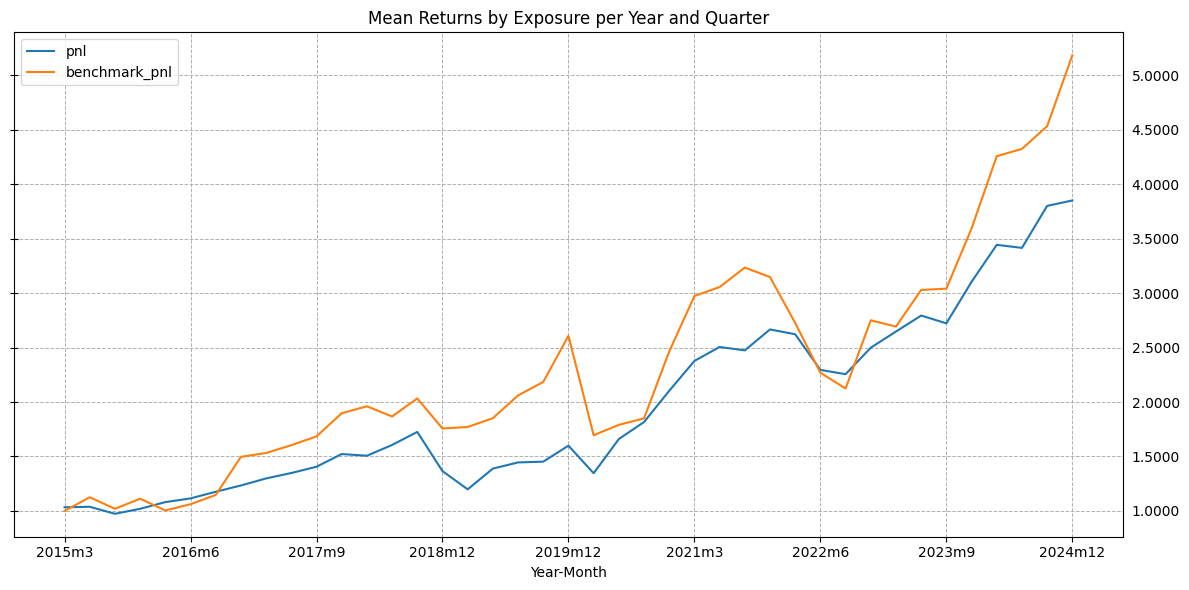

In [22]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
ADSK,1.305038
GEV,1.294101
TOST,1.284378
RDDT,1.257068
TKO,1.253075
...,...
DOCU,0.909492
CPAY,0.876055
Z,0.853282


In [26]:
trades.sort_values("date",ascending=False).dropna()

,year,quarter,ticker,date,adjclose,sell_price,sic_description,ema_volume_corr,coefficient_of_variation,risk,...,group_percentile,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,week
13395,2024,4,HOLX,2024-12-31 00:00:00+00:00,80.560000,72.090000,X-RAY APPARATUS & TUBES & RELATED IRRADIATION ...,4.179294e+05,0.047900,0.047900,...,1.0,1.0,1,0.894861,0.894861,0.894861,Hologic Inc,1.299919e+10,12,1
6574,2024,4,GIS,2024-12-31 00:00:00+00:00,73.246060,63.122589,GRAIN MILL PRODUCTS,4.400573e+05,0.056028,0.056028,...,1.0,1.0,1,0.861788,0.861788,0.861788,"General Mills, Inc.",3.087919e+10,12,1
6594,2024,4,BALL,2024-12-31 00:00:00+00:00,67.137938,54.919339,METAL CANS,1.691832e+06,0.049890,0.049890,...,1.0,1.0,1,0.818008,0.818008,0.818008,Ball Corporation,1.448619e+10,12,1
6593,2024,4,RL,2024-12-31 00:00:00+00:00,190.811726,230.099842,"MEN'S & BOYS' FURNISHGS, WORK CLOTHG, & ALLIED...",6.794890e+06,0.052144,0.052144,...,1.0,1.0,1,1.205900,1.205900,1.205900,Ralph Lauren Corporation,1.359739e+10,12,1
6592,2024,4,HRL,2024-12-31 00:00:00+00:00,31.077530,31.072216,MEAT PACKING PLANTS,-3.488670e+05,0.050343,0.050343,...,1.0,1.0,1,0.999829,0.999829,0.999829,Hormel Foods Corporation,1.660186e+10,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6753,2015,1,AMP,2015-03-31 00:00:00+00:00,105.766321,105.224093,INVESTMENT ADVICE,-4.409467e+05,0.052835,0.052835,...,1.0,1.0,1,0.994873,0.994873,0.994873,"Ameriprise Financial, Inc.",4.449727e+10,3,14
6754,2015,1,A,2015-03-31 00:00:00+00:00,37.284768,38.287734,LABORATORY ANALYTICAL INSTRUMENTS,-1.674664e+05,0.032171,0.032171,...,1.0,1.0,1,1.026900,1.026900,1.026900,Agilent Technologies Inc.,3.051169e+10,3,14
6755,2015,1,TPR,2015-03-31 00:00:00+00:00,27.541551,30.829271,LEATHER & LEATHER PRODUCTS,3.743662e+06,0.034345,0.034345,...,1.0,1.0,1,1.119373,1.119373,1.119373,"Tapestry, Inc. Common Stock",1.425923e+10,3,14
6756,2015,1,MET,2015-03-31 00:00:00+00:00,30.337793,28.651108,LIFE INSURANCE,-1.015863e+06,0.038615,0.038615,...,1.0,1.0,1,0.944403,0.944403,0.944403,"MetLife, Inc.",5.100783e+10,3,14
